In [10]:
!pip install -q kaggle
!pip install -q opencv-python
!pip install -q pydot
!pip install -q graphviz
!pip install -q torchview

In [11]:
# Upload kaggle.json file
# from google.colab import files
# files.upload()

# Remove file if exist
# !rm ~/.kaggle/kaggle.json

# # Create a kaggle directory
# !mkdir -p ~/.kaggle

# # Copy the kaggle.json file to kaggle directory
# !cp kaggle.json ~/.kaggle

# # Fix permissions
# !chmod 600 ~/.kaggle/kaggle.json

In [12]:
# Download the dataset
!kaggle datasets download -d msambare/fer2013
!unzip -o -q fer2013.zip

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
import os
import pandas as pd

# Define a function to caculate the number of each emotion classes
train_dir = './train/'
test_dir = './test/'

def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


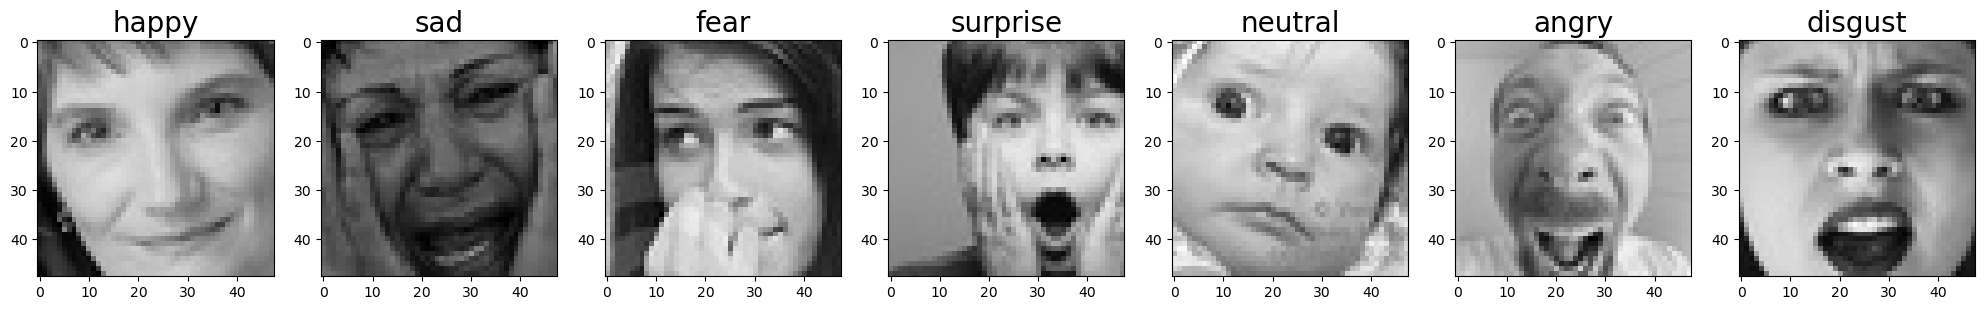

In [14]:
# Show sample images
import matplotlib.pyplot as plt
import cv2

plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = './train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL +'/'+ directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


image_generator = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

training_data = image_generator.flow_from_directory(train_dir,
    target_size=(48,48),
    batch_size=32,
    color_mode = "grayscale",
    class_mode = "categorical"
)

test_data = image_generator.flow_from_directory(test_dir,
    target_size=(48,48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# CNN Model

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(filters = 256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
# Convolutional Layer 2
model.add(Conv2D(filters = 128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
# Convolutional Layer 3
model.add(Conv2D(filters = 128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
# Convolutional Layer 4
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())
## Full connection layer
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(7, activation='softmax'))

model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 44, 44, 256)       73984     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 256)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 22, 22, 256)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 128)       295040    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                  

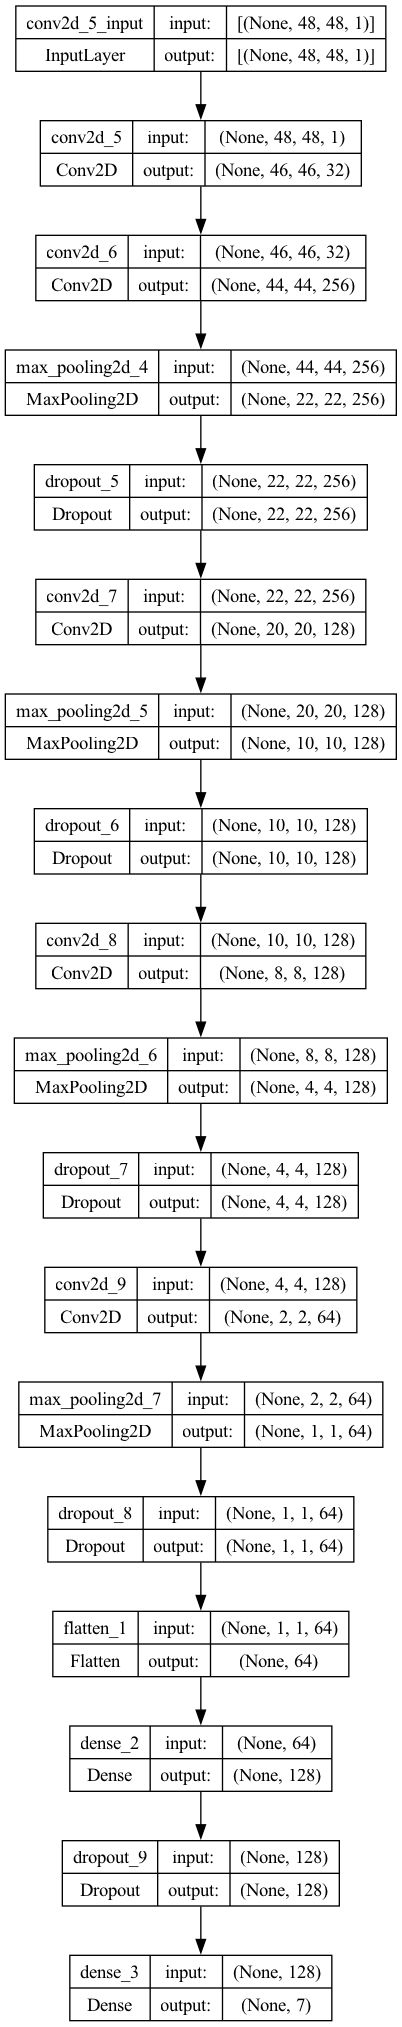

In [17]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
## Training the model
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
history = model.fit(training_data,
    epochs=50,
    batch_size=32,
    validation_data = test_data,
    shuffle=True,
    callbacks = [early_stop]
)

Epoch 1/50


2023-12-01 13:42:40.558729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


898/898 [==============================] - ETA: 0s - loss: 1.8247 - accuracy: 0.2456

2023-12-01 13:45:29.369056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


898/898 [==============================] - 180s 200ms/step - loss: 1.8247 - accuracy: 0.2456 - val_loss: 1.8136 - val_accuracy: 0.2471
Epoch 2/50
898/898 [==============================] - 180s 200ms/step - loss: 1.8115 - accuracy: 0.2518 - val_loss: 1.7958 - val_accuracy: 0.2531
Epoch 3/50
898/898 [==============================] - 179s 199ms/step - loss: 1.7604 - accuracy: 0.2716 - val_loss: 1.6856 - val_accuracy: 0.3077
Epoch 4/50
898/898 [==============================] - 180s 200ms/step - loss: 1.6852 - accuracy: 0.3210 - val_loss: 1.6140 - val_accuracy: 0.3749
Epoch 5/50
898/898 [==============================] - 179s 199ms/step - loss: 1.6096 - accuracy: 0.3647 - val_loss: 1.5035 - val_accuracy: 0.4124
Epoch 6/50
898/898 [==============================] - 180s 200ms/step - loss: 1.5538 - accuracy: 0.3921 - val_loss: 1.4526 - val_accuracy: 0.4345
Epoch 7/50
898/898 [==============================] - 179s 199ms/step - loss: 1.4993 - accuracy: 0.4184 - val_loss: 1.3918 - val_accura

In [ ]:
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12, 4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')
 
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')
 
plt.show()

In [ ]:
loss, accu = model.evaluate(test_data)

print("Loss on test set: ", loss)
print("Accuracy on test set: ", accu)

In [ ]:
model.save('fer_2013_cnn.h5')
model.save_weights('fer_2013_cnn_weights.h5')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
test_labels = test_data.classes
predictions = model.predict(test_data)
predicted_labels = predictions.argmax(axis=1)
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Transfer learning

In [ ]:
import tensorflow as tf

base_model = tf.keras.applications.EfficientNetB0(input_shape=(48,48,3),include_top=False,weights="imagenet")
base_model.summary()

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D, GaussianNoise
from tensorflow.keras import regularizers

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

model.summary()

In [ ]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]


lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=2)

import keras.backend as K

model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)
history=model.fit(training_data,validation_data=test_data,epochs = 50,verbose = 1,callbacks=[lrd,mcp,es])

In [ ]:
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12, 4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
loss,accuracy,precision,recall,auc,f1_score = model.evaluate(test_data)

print("Loss on test set: ", loss)
print("Accuracy on test set: ", accu)

In [ ]:
model.save('fer_2013_trans.h5')
model.save_weights('fer_2013_trans_weights.h5')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
test_labels = test_data.classes
predictions = model.predict(test_data)
predicted_labels = predictions.argmax(axis=1)
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()